Using local data file ./Greenwichlocal.txt
Using local data file ./Derrylocal.txt


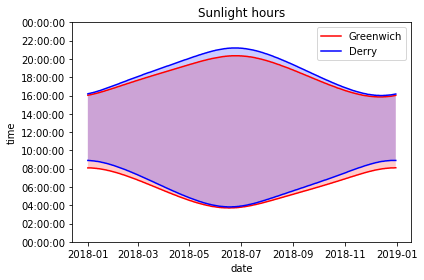

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datetime, os, urllib

"""
Fetches sunrise and sunset data for a calendar year from http://aa.usno.navy.mil 
for a specific set of locations on Earth.  
Wrangles the data and plots data sets for comparison. 

Disclaimer: This script is for educational purposes only. 
            Please do not fetch huge amounts of data from public web servers unnecessarily!
            Instead, use local files if possible.
"""

# Let's make a function that combines all the steps to get the required data series:
def sunrisetimes(key, value, year=2018):

    inFile = r'./%slocal.txt' % key
    if not os.path.exists(inFile): 
        url = "http://aa.usno.navy.mil/cgi-bin/aa_rstablew.pl?ID=AA&year=2018&task=0&place=%s&lon_sign=-1&lon_deg=%s&lon_min=%s&lat_sign=1&lat_deg=%s&lat_min=%s&tz=&tz_sign=-1" % (key, value[0], value[1], value[2], value[3])
        print "Requested data file was not found locally. Fetching it from the interwebs..."
        urllib.urlretrieve (url, inFile)

        # Dirty and dumb way to get rid of the html and css before the data table:
        f = open(inFile, 'r')
        # Gets a list of all the lines in the file, with each line as an un-split string.
        # Crucially, the line endings remain intact so the local file will be identical to the original raw text! 
        html=f.readlines()
        f.close()
        raw = html[25:66] # Slice only the lines that we need. This is hardcoded but was the best method I found. 

        # Create/OverWrite the local file:
        with open(inFile, "w") as text_file:
            for line in raw:
                text_file.write(line)
    else:
        print "Using local data file %s" % inFile

    # Read in data file:
    eg = pd.read_fwf(inFile, colspecs=[(0,2), (4,8)], skiprows=9, header=None)
    # Split up by column: Again, hardcoded but was the most reliable method. 
    sunrise = pd.read_fwf(inFile, colspecs=[(i, i+4) for i in range(4,132,11)], skiprows=9, header=None).values.T.flatten()
    sunset  = pd.read_fwf(inFile, colspecs=[(i, i+4) for i in range(9,137,11)], skiprows=9, header=None).values.T.flatten()
    # Remove NaN values for shorter months:
    sunrise = sunrise[~np.isnan(sunrise)].astype('int').tolist()
    sunset = sunset[~np.isnan(sunset)].astype('int').tolist()
    # Convert list of date strings to list of datetimes:
    srise = [datetime.time(int(str(a)[:-2]), int(str(a)[-2:]), 0) for a in sunrise]
    sset = [datetime.time(int(str(a)[:-2]), int(str(a)[-2:]), 0) for a in sunset]
    return srise, sset

year = 2018
periodlist = pd.date_range(start='%s-01-01' % year, end='%s-12-31' % year, freq='D')
datelist = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in periodlist]

# Dictionary. Key is the place name label, value is a 4-tuple containing Longitude West in Degrees and Minutes then Latitude North in Degrees and Minutes:
places = {"Greenwich": (0, 0, 51, 28), "Derry": (7, 14, 55, 0)}
# This code allows you to add further locations, but it doesn't really make a nice plot to include too many at once!:
##places = {"Greenwich": (0, 0, 51, 28), "Derry": (7, 14, 55, 0), "Lowestoft": (1, 45, 52, 28)}

# Create a nice plot for both series:
plt.figure()

# Visualization:

# Create a list of usable colors for later. Could also use a built-in list from matplotlib! 
colors = ['red', 'blue', 'green', 'yellow'] # This would work for up to four places.

# Loop through the places and the colors:
for (key, value), color in zip(places.iteritems(), colors):
    
    # Construct a file name for the local file using the location name in the dictionary key:
    inFile = r'./%slocal.txt' % key
    
    # Call the sunrisetimes function:
    sunrise, sunset = sunrisetimes(key, value)
    
    # Plot the returned data as line plots:
    plt.plot(datelist, sunrise, label=key, color=color)
    plt.plot(datelist, sunset, color=color)

    # Puts a fill between the sunrise and sunset line plots:
    plt.fill_between(datelist, sunset, sunrise, facecolor=color, alpha=0.2, interpolate=True)

# Tweak plot title and axis labels:
plt.title('Sunlight hours')
plt.xlabel('date')

# Make sure the y axis covers the (almost) full range of 24 hours:
plt.ylim([datetime.time.min, datetime.time.max]) 
# The above y limits do not force the y axis to run a full 24 hours, so force manual axes tick values.
# Give a range of values in seconds and matplotlib is clever enough to work it out:
plt.yticks(range(0, 60*60*25, 2*60*60))

plt.legend()
plt.tight_layout()
plt.savefig('final2.png', dpi=90)
plt.show()